In [ ]:
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git

  Cloning https://github.com/google/lightweight_mmm.git to /tmp/pip-req-build-5bu5_mu4
  Running command git clone --filter=blob:none --quiet https://github.com/google/lightweight_mmm.git /tmp/pip-req-build-5bu5_mu4
  Resolved https://github.com/google/lightweight_mmm.git to commit 8152c43c8b52eb8c020c1c54c7e4bfa5140e42d0
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
from lightweight_mmm import preprocessing, lightweight_mmm, plot, optimize_media
import jax.numpy as jnp
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

## test

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/나스업무/mmm/rawdata/Sr Advertising Analyst Work Sample (1).xlsx')

- 온라인 광고 캠페인을 운영할 때, 여러 광고 그룹을 만들고 각 그룹에 다른 대상을 설정하며 광고를 게재합니다. 어트리뷰션과 마케팅 믹스 모델을 사용하여 광고 그룹의 성과를 평가하고 최적화할 수 있습니다.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9586 entries, 0 to 9585
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   9586 non-null   datetime64[ns]
 1   Brand Alias            9586 non-null   object        
 2   Ad group alias         9586 non-null   object        
 3   ASIN/SKU Alias         9586 non-null   object        
 4   Marketplace            9586 non-null   object        
 5   Impressions            9586 non-null   int64         
 6   Clicks                 9586 non-null   int64         
 7   Spend                  9586 non-null   float64       
 8   Sales                  9586 non-null   float64       
 9   Orders                 9586 non-null   int64         
 10  Units                  9586 non-null   int64         
 11  Advertised Units sold  9586 non-null   int64         
 12  Other SKU units sold   9586 non-null   int64         
 13  Adv

In [ ]:
agg_data = data.groupby(["Date", "Ad group alias"])[["Impressions","Spend", "Sales",]].sum()
agg_data = agg_data.drop(["Brand 1 Ad Group 12"], axis=0, level=1) # zero cost train
agg_data

Impressions     Spend       Sales
Date       Ad group alias                                        
2021-10-17 Brand 1 Ad Group 1          3317    10.650    454.8875
           Brand 1 Ad Group 10           33     0.000      0.0000
           Brand 1 Ad Group 11        50966   144.190   1556.5775
           Brand 1 Ad Group 13         9519    18.550    352.6475
           Brand 1 Ad Group 2         40265   228.334   4105.9775
...                                     ...       ...         ...
2022-01-11 Brand 2 Ad Group 1        280184   623.966   7801.2500
           Brand 2 Ad Group 2        836804  1210.212  14389.9775
           Brand 2 Ad Group 3         56667    74.260   1235.5575
           Brand 2 Ad Group 4         33431    41.030    177.9000
           Brand 2 Ad Group 5          9885    11.152    876.4250

[1411 rows x 3 columns]

In [ ]:
media_data_raw = agg_data['Impressions'].unstack().fillna(0)
costs_raw = agg_data['Spend'].unstack()
sales_raw = agg_data['Sales'].reset_index().groupby("Date").sum()

<ipython-input-51-df1531b5b5e9>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_raw = agg_data['Sales'].reset_index().groupby("Date").sum()


- 노출 횟수는 광고를 50% 이상 본 횟수를 의미하며, 광고 효과를 측정하는 중요한 지표입니다. 라이트웨이트MMM 모델은 광고 그룹별 지출을 고려하며, 판매 금액을 예측하기 위한 검증에는 시간 분할을 사용합니다. 다만, 검증에는 크리스마스와 같은 특별한 날짜의 영향을 고려하기 어렵다는 한계가 있습니다.

In [ ]:
split_point = pd.Timestamp("2021-12-15")

In [ ]:
media_data_train = media_data_raw.loc[:split_point - pd.Timedelta(1,'D')]
media_data_test = media_data_raw.loc[split_point:]

In [ ]:
organic_data_train = organic_raw.loc[:split_point - pd.Timedelta(1,'D')]
organic_data_test = organic_raw.loc[split_point:]

In [ ]:
target_train = sales_raw.loc[:split_point - pd.Timedelta(1,'D')]
target_test = sales_raw.loc[split_point:]

In [ ]:
costs_train = costs_raw.loc[:split_point - pd.Timedelta(1,'D')].sum(axis=0).loc[media_data_train.columns]

In [ ]:
organic_raw = pd.DataFrame({'organic_search': 0, 'organic_social': 0}, index=media_data_raw.index)
organic_raw['organic_search'] = sales_raw.values/10 + np.random.random_integers(10000, 100000, organic_raw.shape[0])
organic_raw['organic_social'] = sales_raw.values/10 + np.random.random_integers(10000, 100000, organic_raw.shape[0])

<ipython-input-57-db9eaf7cabe0>:2: DeprecationWarning: This function is deprecated. Please call randint(10000, 100000 + 1) instead
  organic_raw['organic_search'] = sales_raw.values/10 + np.random.random_integers(10000, 100000, organic_raw.shape[0])
<ipython-input-57-db9eaf7cabe0>:3: DeprecationWarning: This function is deprecated. Please call randint(10000, 100000 + 1) instead
  organic_raw['organic_social'] = sales_raw.values/10 + np.random.random_integers(10000, 100000, organic_raw.shape[0])


### Scaling Data

- LightweightMMM에서는 0이 많은 데이터에 대해 다른 스케일러를 사용하여 모든 변수를 확장하고, 이를 통해 정확한 미디어 효과를 추정하고 최적화 도구에 적합한 계수를 찾는데 도움이 되는 중요한 단계입니다.

In [ ]:
costs_train = costs_raw.loc[:split_point - pd.Timedelta(1,'D')].sum(axis=0).loc[media_data_train.columns]

In [ ]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
organic_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

In [ ]:
media_data_train_scaled = media_scaler.fit_transform(media_data_train.values)
organic_data_train_scaled = organic_scaler.fit_transform(organic_data_train.values)
target_train_scaled = target_scaler.fit_transform(target_train.values.squeeze())
costs_scaled = cost_scaler.fit_transform(costs_train.values)

In [ ]:
media_data_test_scaled = media_scaler.transform(media_data_test.values)
organic_data_test_scaled = organic_scaler.transform(organic_data_test.values)

In [ ]:
media_names = media_data_raw.columns

### 최적의 파라미터 찾기

In [ ]:
adstock_models = ["adstock", "hill_adstock", "carryover"]
degrees_season = [1,2,3]

adstock_models = ["hill_adstock"]
degrees_season = [1]

In [ ]:
for model_name in adstock_models:
    for degrees in degrees_season:
        mmm = lightweight_mmm.LightweightMMM(model_name=model_name)
        mmm.fit(media=media_data_train_scaled,
                media_prior=costs_scaled,
                target=target_train_scaled,
                extra_features=organic_data_train_scaled,
                number_warmup=1000,
                number_samples=1000,
                number_chains=1,
                degrees_seasonality=degrees,
                weekday_seasonality=True,
                seasonality_frequency=365,
                seed=1)

        prediction = mmm.predict(
            media=media_data_test_scaled,
            extra_features=organic_data_test_scaled,
            target_scaler=target_scaler)
        p = prediction.mean(axis=0)

        mape = mean_absolute_percentage_error(target_test.values, p)
        print(f"model_name={model_name} degrees={degrees} MAPE={mape} samples={p[:3]}")

sample: 100%|██████████| 2000/2000 [03:24<00:00,  9.79it/s, 1023 steps of size 1.89e-04. acc. prob=0.90]


model_name=hill_adstock degrees=1 MAPE=0.13497329951045006 samples=[24458.791 26279.145 28434.121]


- 이 결과는 어떤 모델(`model_name=hill_adstock`)과 계절성 차수(`degrees=1`)에 대한 정보를 제공합니다.

- `sample: 100%|██████████| 2000/2000 [03:15<00:00, 10.21it/s, 1023 steps of size 1.89e-04. acc. prob=0.90]`: 모델 학습 및 샘플링이 100% 완료되었으며, 총 2000개의 샘플이 사용되었습니다. 이 과정은 약 3분 15초 소요되었으며, 샘플링 과정에서 1023개의 스텝(step)이 실행되었습니다. 정확한 확률(accuracy probability)은 약 0.90입니다.

- `MAPE=0.13497329951045006`: MAPE(Mean Absolute Percentage Error)는 예측 모델의 정확도를 나타내는 지표로, 값이 낮을수록 모델이 더 정확합니다. 여기서 MAPE 값은 약 0.1349로 나타나며, 예측 오차가 상대적으로 낮음을 나타냅니다.

- `samples=[24458.791 26279.145 28434.121]`: 예측 결과로서, 첫 번째, 두 번째, 세 번째 시점에서의 판매량(또는 다른 대상 변수) 예측값을 나타냅니다. 예를 들어, 첫 번째 시점에서의 예측 판매량은 약 24458.791, 두 번째 시점에서는 약 26279.145, 세 번째 시점에서는 약 28434.121로 나타납니다. 이 값들은 해당 모델 및 계절성 설정에 따른 예측 결과를 나타냅니다.

- 예측 메서드는 각 체인에 대한 샘플을 출력합니다. 포인트 추정치를 얻기 위해 샘플의 평균을 구합니다.

- 이 모델은 주별 데이터에도 사용할 수 있으므로 일별 데이터와 함께 사용하려면 weekday_seasonality 매개 변수를 사용하고 계절성 효과를 올바르게 포착하기 위해 seasonality_frequency 매개 변수를 조정해야 합니다

### Retraining LightweightMMM
- 최적의 하이퍼파라미터 조합을 찾은 후에는 이제 모든 데이터를 사용하여 모델을 재학습합니다.

- 다른 모델에서와 마찬가지로 이월 광고재고와 계절성 정도 = 1이 가장 좋은 조합이었습니다. 하지만 Colab에서 실행하는 데 20분 이상 걸리기 때문에 이보다 더 나쁘지는 않지만 2분 안에 실행되는 hill_adstock으로 결정했습니다.

- 온라인 광고 캠페인 데이터는 매우 빠르게 변경되므로 항상 가장 최신 패턴으로 작업하기 위해 매일 모델을 재교육하는 것이 좋습니다.

- 데이터가 더 많다면 추가적으로 할 수 있는 실험은 학습에 가장 적합한 창 크기를 찾는 것입니다. 예를 들어, 최근 3개월, 6개월 또는 12개월의 데이터를 사용하여 모델을 학습시키는 것이 더 좋을까요?

- 어떤 것이 가장 좋은 오차를 제공하는지 직접 시도해 보지 않고는 알 수 없습니다. 제로 인플레이션 마케팅 믹스 모델 문서에서 설명한 것처럼 말이죠.

In [ ]:
costs = costs_raw.sum(axis=0).loc[media_names]

In [ ]:
# 데이터 스케일링
# media_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)
# organic_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)
# target_scaler2 = preprocessing.CustomScaler(
#     divide_operation=jnp.mean)
# cost_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)
media_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)
organic_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)

In [ ]:
media_data_scaled = media_scaler2.fit_transform(media_data_raw.values)
organic_data_scaled = organic_scaler2.fit_transform(organic_raw.values)
target_scaled = target_scaler2.fit_transform(sales_raw.values)
costs_scaled2 = cost_scaler2.fit_transform(costs.values)

media_names = media_data_raw.columns

mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")
mmm.fit(media=media_data_scaled,
        media_prior=costs_scaled2,
        extra_features=organic_data_scaled,
        target=target_scaled,
        number_warmup=1000,
        number_samples=1000,
        number_chains=1,
        degrees_seasonality=1,
        weekday_seasonality=True,
        seasonality_frequency=365,
        seed=1)

sample: 100%|██████████| 2000/2000 [05:13<00:00,  6.37it/s, 1023 steps of size 8.80e-04. acc. prob=0.96]


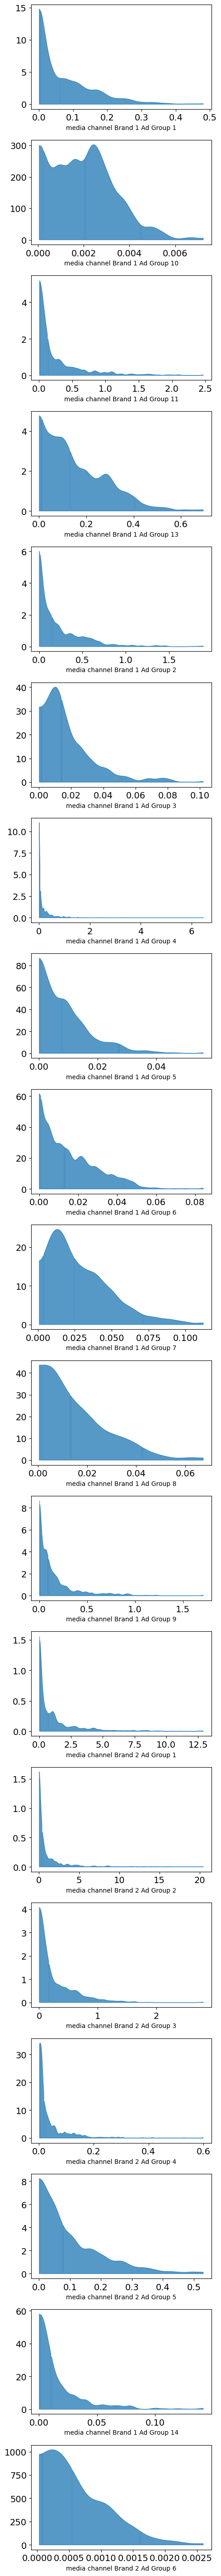

In [ ]:
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=media_names)

In [ ]:
prices = costs / media_data_raw.sum(axis=0)
budget = 1 # your budget here
solution = optimize_media.find_optimal_budgets(
    n_time_periods=10,
    media_mix_model=mmm,
    extra_features=organic_data_scaled[-10:, :],
    budget=budget,
    prices=prices.values)

In [ ]:
agg_data = data.groupby(["Date", "Ad group alias", "Marketplace"])[["Impressions","Spend", "Sales",]].sum()
agg_data = agg_data.drop(["Brand 1 Ad Group 12"], axis=0, level=1) # zero cost train

media_data_raw_ = agg_data['Impressions'].unstack(level=1).fillna(1) # scaler goes crazy if fillna = 0 because of division by zero
sales_raw_ = agg_data['Sales'].reset_index().groupby(["Date", "Marketplace"]).sum()
costs_raw = data.groupby(["Date", "Ad group alias"])[["Spend"]].sum().drop(["Brand 1 Ad Group 12"], axis=0, level=1).unstack()

media_concat = list()
sales_concat = list()
for marketplace in ["Amazon", "Ebay", "Walmart"]:
    df_ = media_data_raw_.loc[(media_data_raw_.index.get_level_values(0), marketplace), :].values
    df_ = np.expand_dims(df_, 2)
    media_concat.append(df_)

    sdf_ = sales_raw_.loc[(sales_raw_.index.get_level_values(0), marketplace), :].values
    #sdf_ = np.expand_dims(sdf_, 1)
    sales_concat.append(sdf_)

media_data_raw = np.concatenate(media_concat, axis=2)
sales_raw = np.concatenate(sales_concat, axis=1)

split_point = -28

media_data_train = media_data_raw[:split_point, :, :]
media_data_test = media_data_raw[split_point:, :, :]

target_train = sales_raw[:split_point, :]
target_test = sales_raw[split_point:, :]

media_names = media_data_raw_.columns

costs_train = costs_raw.iloc[:split_point].sum(axis=0)

media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(
    divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train_scaled = media_scaler.fit_transform(media_data_train)

target_train_scaled = target_scaler.fit_transform(target_train.squeeze())
costs_scaled = cost_scaler.fit_transform(costs_train.values)

media_data_test_scaled = media_scaler.transform(media_data_test)